In [1]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import math

# visualizations
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics, preprocessing

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

KUMPULAN FUNGSI

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res['inv_'+str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')

INPUT DATA

In [2]:
dataTA = pd.read_csv('dataTA.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'
print(dataTA.shape) 
dataTA.head()

(120, 4)


,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-01-01,436.0,23.06,77.55,2.80
2012-02-01,493.0,23.50,78.69,6.33
2012-03-01,519.0,23.50,74.48,5.33
2012-04-01,482.0,24.00,81.00,3.00
2012-05-01,573.0,23.60,77.23,6.75


PLOT DATA   

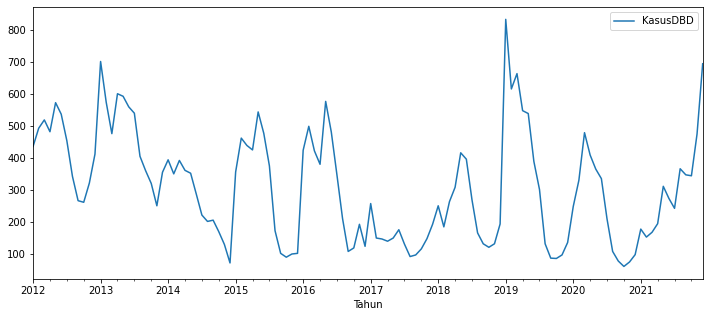

In [7]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['KasusDBD'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)



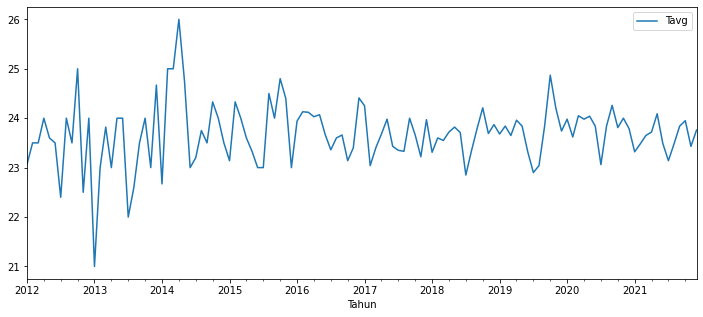

In [8]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['Tavg'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

UJI STASIONER

In [9]:
data=dataTA[['KasusDBD', 'Tavg']]
data.columns = ['KasusDBD', 'Tavg']
data.shape

(120, 2)

In [10]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Tavg
Test Statistic                  -3.634114
p-value                          0.005141
No Lags Used                    12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




UJI KORELASI

In [ ]:
data.corr()

Text(0.5, 1.0, 'Partial Autocorrelation Function Kasus DBD')

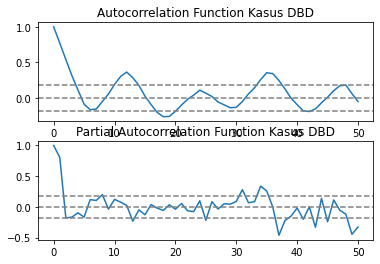

In [11]:
  #KASUS DBD
  KasusDBD_acf = acf(data['KasusDBD'], nlags=50)
  KasusDBD_pacf = pacf(data['KasusDBD'], nlags=50, method='ols')

  #Plot ACF: 
  plt.subplot(211) 
  plt.plot(KasusDBD_acf)
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(data['KasusDBD'])),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(data['KasusDBD'])),linestyle='--',color='gray')
  plt.title(f'Autocorrelation Function Kasus DBD')

  #Plot PACF:
  plt.subplot(212)
  plt.plot(KasusDBD_pacf)
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(data['KasusDBD'])),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(data['KasusDBD'])),linestyle='--',color='gray')
  plt.title('Partial Autocorrelation Function Kasus DBD')

Text(0.5, 1.0, 'Partial Autocorrelation Function TAVG')

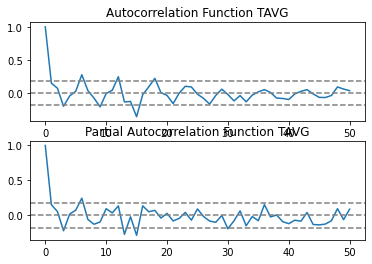

In [12]:
#TAVG
Tavg_acf = acf(data['Tavg'], nlags=50)
Tavg_pacf = pacf(data['Tavg'], nlags=50, method='ols')

#Plot ACF: 
plt.subplot(211) 
plt.plot(Tavg_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['Tavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['Tavg'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function TAVG')

#Plot PACF:
plt.subplot(212)
plt.plot(Tavg_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['Tavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['Tavg'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function TAVG')

AUTO ARIMA

In [13]:
pq = []
for name, column in data[['KasusDBD','Tavg']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : KasusDBD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1475.456, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1750.751, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1474.227, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1641.998, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1475.370, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1477.256, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1464.749, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1579.728, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1463.017, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1461.898, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1462.849, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1462.466, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1461.302, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1464.099, Time=

In [14]:
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        model = VARMAX(data[['KasusDBD','Tavg']], order=(i[0],i[2]))
        result=model.fit( disp=False)
        print(f'VARMA Order {i}')
        print('AIC {}'.format(result.aic))
        print('BIC {}'.format(result.bic))
        print()

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA Order (2, 0, 1)
AIC 1708.147604010536
BIC 1755.5349636378307

VARMA Order (0, 0, 3)
AIC 1740.4446843343253
BIC 1787.83204396162



c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
varma_model = VARMAX(data[['KasusDBD','Tavg']], order=(2,1),enforce_stationarity= True)
fitted_model = varma_model.fit(disp=False)
print(fitted_model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                            Statespace Model Results                            
Dep. Variable:     ['KasusDBD', 'Tavg']   No. Observations:                  120
Model:                       VARMA(2,1)   Log Likelihood                -837.074
                            + intercept   AIC                           1708.148
Date:                  Thu, 04 Aug 2022   BIC                           1755.535
Time:                          07:49:40   HQIC                          1727.392
Sample:                      01-01-2012                                         
                           - 12-01-2021                                         
Covariance Type:                    opg                                         
Ljung-Box (L1) (Q):             0.04, 0.09   Jarque-Bera (JB):        466.17, 30.19
Prob(Q):                        0.84, 0.76   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.29, 0.17   Skew:                      2.18, -0.31
Prob(H) (two-sided)

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
data.corr()

,KasusDBD,Tavg
KasusDBD,1.000000,-0.162691
Tavg,-0.162691,1.000000


In [17]:

predict = fitted_model.get_prediction(start=0,end=len(data)-1)
prediction=predict.predicted_mean

In [18]:
prediction.columns=['KasusDBD','Tavg']
prediction

,KasusDBD,Tavg
Tahun,,
2012-01-01,317.732510,23.670515
2012-02-01,401.139053,23.500934
2012-03-01,462.739229,23.518008
2012-04-01,473.191350,23.533720
2012-05-01,440.277888,23.615166
...,...,...
2021-08-01,246.183236,23.598959
2021-09-01,379.456879,23.601794
2021-10-01,342.691269,23.680093


In [19]:
for i in ['KasusDBD','Tavg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(data[str(i)] , prediction[str(i)])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 10644.626471434776
MAE is : 71.1464342337293
RMSE is : 103.17279908694334
MAPE is : 0.3043741994507727

Evaluation metric for Tavg
Evaluation metric results:-
MSE is : 0.37088146916313175
MAE is : 0.4423258825006241
RMSE is : 0.6090003851912835
MAPE is : 0.018756254481723262



<AxesSubplot:xlabel='Tahun'>

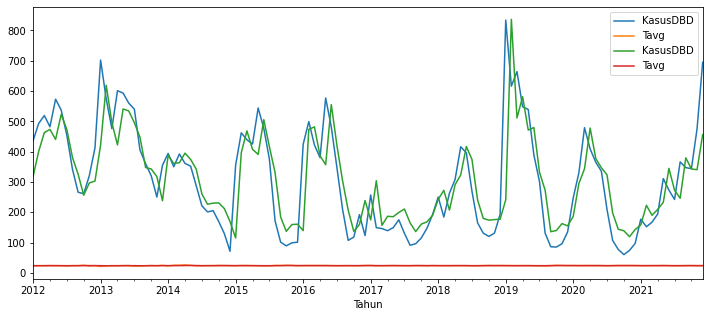

In [20]:
test_vs_pred=pd.concat([data[['KasusDBD','Tavg']],prediction],axis=1)
test_vs_pred.plot(figsize=(12,5))

In [21]:
forecast = fitted_model.get_prediction(start=1,end=len(data)+11)
forecast=forecast.predicted_mean
forecast

,KasusDBD,Tavg
2012-02-01,401.139053,23.500934
2012-03-01,462.739229,23.518008
2012-04-01,473.191350,23.533720
2012-05-01,440.277888,23.615166
2012-06-01,522.954728,23.557499
...,...,...
2022-08-01,326.312277,23.643211
2022-09-01,321.997960,23.655194
2022-10-01,319.769605,23.662234
2022-11-01,318.660501,23.666194


<AxesSubplot:>

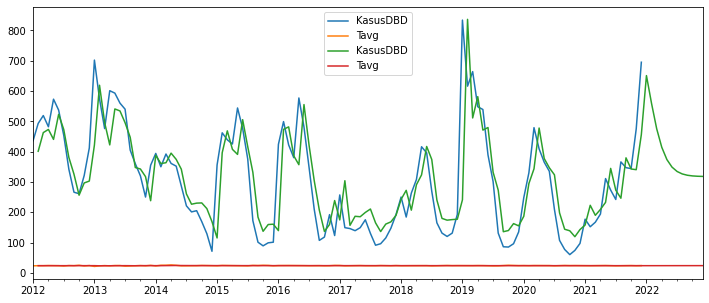

In [22]:
test_vs_forecast=pd.concat([data[['KasusDBD','Tavg']],forecast],axis=1)
test_vs_forecast.plot(figsize=(12,5))

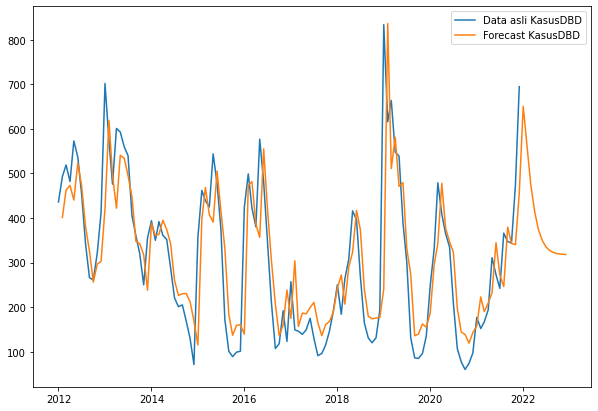

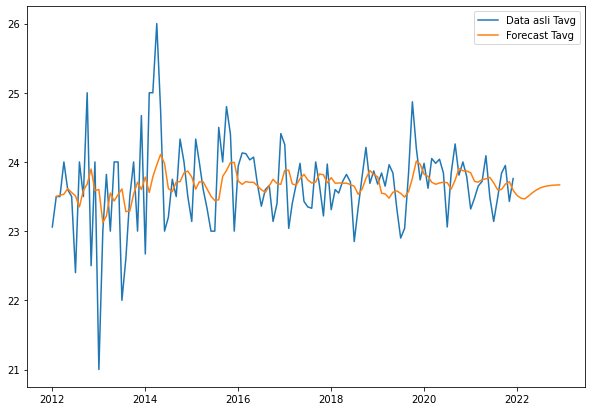

In [23]:
for i in ['KasusDBD','Tavg']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(data[str(i)], label='Data asli '+str(i))
    plt.plot(forecast[str(i)], label='Forecast '+str(i))
    plt.legend(loc='best')
    plt.show()